# Lens modeling with lenstronomy

Author: Nahid,  Anowar Shajib \
Acknowledgement: Tanjela, Nushrat, Imtiaz.

In [27]:
# import of standard python libraries
import h5py
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import joblib

# make sure corner is installed, otherwise install the latest pip version
try:
    import corner
except:
    !pip install corner

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

## Load imaging data

In [13]:
import h5py

with h5py.File('/content/DESIJ1501+5208_F140W.h5','r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
        
kwargs_data


{'background_rms': 0.014963332106321819,
 'dec_at_xy_0': -4.839999999999995,
 'exposure_time': array([[488.64148, 566.09674, 345.7502 , ..., 459.5809 , 518.8    ,
         407.5115 ],
        [401.22644, 398.9151 , 534.8668 , ..., 448.52478, 412.19623,
         524.1561 ],
        [527.65265, 489.20187, 461.2098 , ..., 468.7077 , 569.2436 ,
         461.83698],
        ...,
        [505.7458 , 427.0192 , 414.52997, ..., 502.91226, 443.75787,
         395.43372],
        [376.59488, 531.478  , 506.44412, ..., 384.07312, 413.83487,
         591.86597],
        [544.9653 , 370.8008 , 440.23788, ..., 551.08405, 494.0987 ,
         401.69803]], dtype=float32),
 'image_data': array([[ 0.00703234,  0.00361226, -0.00145792, ...,  0.00880749,
         -0.00725319, -0.01772221],
        [ 0.00450083, -0.00962588, -0.0024846 , ...,  0.00497274,
          0.0074176 , -0.01311936],
        [ 0.00980921,  0.0070102 ,  0.00502042, ...,  0.00979241,
          0.0144872 ,  0.00252407],
        ...,
   

In [14]:
with h5py.File('/content/psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
        
kwargs_psf['psf_type'] = 'PIXEL'
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

### Visualizing the data

<ipython-input-5-e61b199732fb>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');


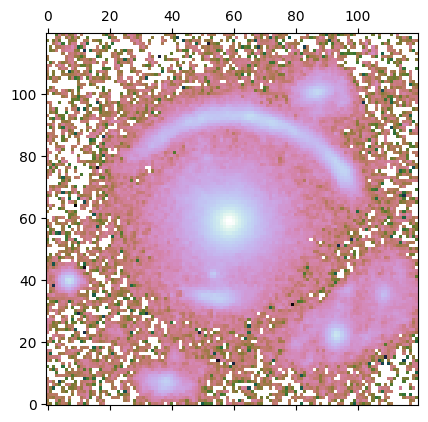

In [5]:
image_data = kwargs_data['image_data']
plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');

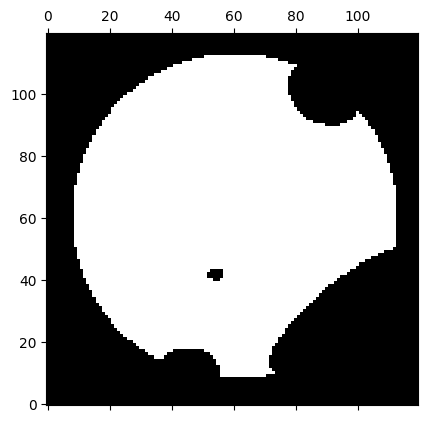

<ipython-input-17-0cbfa9b40bf2>:85: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data),
<ipython-input-17-0cbfa9b40bf2>:85: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data),


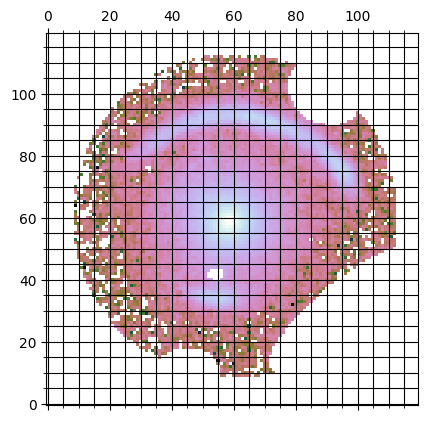

In [17]:
from lenstronomy.Util import mask_util
from lenstronomy.Util import util

from lenstronomy.Data.coord_transforms import Coordinates


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 4.2 # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# for the galaxy at 1 o clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.3,
    lens_center_dec + 3.2,
    1.0,
    0.8,
    np.pi/0.85,
)


# for the galaxy at 5 o clock
mask_ext_2= mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec - 2.4,
    2.5,
    0.76,
    np.pi/0.56,
)


# for the galaxy at 7 o clock
mask_ext_3= mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.2,
    lens_center_dec - 4.0,
    0.8,
    0.6,
    0,
)

# for the galaxy at center
mask_ext_4= mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.5,
    lens_center_dec - 1.5,
    0.2,
    0.15,
    0,
)

mask = (1 - mask_outer) * (1 - mask_ext_1) * (1 - mask_ext_2) * (1 - mask_ext_3) * (1 - mask_ext_4)
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = mask.reshape(num_pix, num_pix)
plt.matshow(mask, origin='lower', cmap='cubehelix')
plt.show()

# applying the mask
masked_image_data = np.multiply(image_data, mask)

plt.matshow(np.log10(masked_image_data), 
            origin='lower', cmap='cubehelix')
plt.grid(which='both', color='black')
plt.minorticks_on()
plt.grid(which='minor', color='black')
plt.show()

## Building the lens model

In [18]:
lens_model_list = ['EPL', 'SHEAR'] 
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS'] 
lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

### Mass model of the lens galaxy

In [19]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# setting EPL parameters
fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 2.5065, 
                         'gamma': 2.9999, 
                         'e1': 0.0048, 
                         'e2': 0.0160,
                         'center_x':0.1409, 
                         'center_y': -0.1469})
kwargs_lens_sigma.append({'theta_E': .2, 
                          'gamma': .1, 
                          'e1': 0.05, 
                          'e2': 0.05,
                         'center_x': 0.5, 
                          'center_y': 0.5})
kwargs_lower_lens.append({'theta_E': 2., 
                          'gamma': 1.5,
                          'e1': -0.5,
                          'e2': -0.5, 
                          'center_x': -10, 
                          'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10., 
                          'gamma': 3., 
                          'e1': 0.5, 
                          'e2': 0.5,
                          'center_x': 10, 
                          'center_y': 10})

# setting SHEAR Parameters
fixed_lens.append({'ra_0': 0,
                   'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.1797,
                         'gamma2': -0.0252,
                         'ra_0': 0,
                         'dec_0': 0})
kwargs_lens_sigma.append({'gamma1': 0.1,
                          'gamma2': 0.1,
                          'ra_0': 0,
                          'dec_0': 0})
kwargs_lower_lens.append({'gamma1': -0.3,
                          'gamma2': -0.3,
                          'ra_0': -100,
                          'dec_0': -100})
kwargs_upper_lens.append({'gamma1': 0.3,
                          'gamma2': 0.3,
                          'ra_0': 100,
                          'dec_0': 100})

### Light model of the source galaxy

In [20]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# setting SERSIC_ELLIPSE parameters
fixed_source.append({'n_sersic': 1.})
kwargs_source_init.append({'R_sersic': 6.8295, 
                           'n_sersic': 1., 
                           'e1': -0.0709, 
                           'e2': 0.4999, 
                           'center_x': 0.0060, 
                           'center_y': 0.8214, 
                           'amp': 16})
kwargs_source_sigma.append({'n_sersic': 0.5, 
                            'R_sersic': 0.1, 
                            'e1': 0.05, 
                            'e2': 0.05, 
                            'center_x': 0.2, 
                            'center_y': 0.2,
                            'amp': 10})
kwargs_lower_source.append({'e1': -0.5, 
                            'e2': -0.5, 
                            'R_sersic': 0.001, 
                            'n_sersic': .5, 
                            'center_x': -10, 
                            'center_y': -10,
                            'amp': 0})
kwargs_upper_source.append({'e1': 0.5, 
                            'e2': 0.5, 
                            'R_sersic': 10, 
                            'n_sersic': 5., 
                            'center_x': 10, 
                            'center_y': 10,
                            'amp': 100})

# setting SHAPELETS parameters
fixed_source.append({'n_max': 8})
kwargs_source_init.append({'beta': 0.1991, 
                           'center_x':0.0060, 
                           'center_y': 0.8214})
kwargs_source_sigma.append({'beta': 0.1, 
                            'center_x': 0.2, 
                            'center_y': 0.2})
kwargs_lower_source.append({'beta': 0.001, 
                            'center_x': -10, 
                            'center_y': -10})
kwargs_upper_source.append({'beta': 8, 
                            'center_x': 10, 
                            'center_y': 10})


### Light model of the lens galaxy

In [21]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


#1st sersic
fixed_lens_light.append({'n_sersic': 1.0})

kwargs_lens_light_init.append(
    {
         'R_sersic': 0.5767, 
         'n_sersic': 1.0, 
         'e1': 0.0018, 
         'e2': 0.0175, 
         'center_x': 0.1417, 
         'center_y': -0.148,
         'amp': 16, 
    }
)
kwargs_lens_light_sigma.append(
    {
        'n_sersic': 1,
        'R_sersic': 0.3,
        'e1': 0.05,
        'e2': 0.05,
        'center_x': 0.1,
        'center_y': 0.1,
        'amp': 1,
    }
)
kwargs_lower_lens_light.append(
    {
        'e1': -0.5,
        'e2': -0.5,
        'R_sersic': 0.001,
        'n_sersic': 0.5,
        'center_x': -10,
        'center_y': -10,
        'amp': 0,
    }
)
kwargs_upper_lens_light.append(
    {
        'e1': 0.5,
        'e2': 0.5,
        'R_sersic': 10,
        'n_sersic': 5.0,
        'center_x': 10,
        'center_y': 10,
        'amp': 100,
    }
)

#2nd sersic
fixed_lens_light.append({'n_sersic': 4. })
kwargs_lens_light_init.append({'R_sersic': 0.6714, 
                               'n_sersic': 4., 
                               'e1': 0.0048, 
                               'e2': 0.0161, 
                               'center_x': 0.1409, 
                               'center_y': -0.1469, 
                               'amp': 1})
kwargs_lens_light_sigma.append({'n_sersic': 1, 
                                'R_sersic': 0.3, 
                                'e1': 0.05, 
                                'e2': 0.05, 
                                'center_x': 0.1, 
                                'center_y': 0.1, 
                                'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5, 
                                'e2': -0.5, 
                                'R_sersic': 0.001, 
                                'n_sersic': .5, 
                                'center_x': -10, 
                                'center_y': -10,
                                'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 
                                'e2': 0.5, 
                                'R_sersic': 10, 
                                'n_sersic': 5., 
                                'center_x': 10, 
                                'center_y': 10, 
                                'amp': 100})

### Combining source and lens models

In [22]:
joint_shapelets_with_sersic = [[0, 1, ['center_x', 'center_y']]]

joint_lens_light_with_lens_light = [[0, 1, ['center_x', 'center_y']]]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, 
               kwargs_lower_lens, kwargs_upper_lens] 
    
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, 
                 kwargs_lower_source, kwargs_upper_source]

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, 
                     fixed_lens_light, kwargs_lower_lens_light, 
                     kwargs_upper_lens_light]  


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {'joint_source_with_source': joint_shapelets_with_sersic,
                      'joint_lens_light_with_lens_light':joint_lens_light_with_lens_light }

## Numerical Settings

In [23]:
kwargs_likelihood = {'check_bounds': True,
                     "image_likelihood_mask_list": [mask]}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False
                   }

### Combining all the information to be sent to lenstronomy

In [24]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'
                    }

## Model fiting

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, 
                              kwargs_constraints, kwargs_likelihood, 
                              kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 
                                'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.8539406762488623 reduced X^2 of best position
-3218.929379120086 log likelihood
7539 effective number of data points
[{'theta_E': 2.51544013197305, 'gamma': 2.1685728824689083, 'e1': -0.05199593172934767, 'e2': -0.08850052870134757, 'center_x': 0.0873942060280881, 'center_y': -0.6375116821995758}, {'gamma1': 0.08017036221202804, 'gamma2': -0.009075649592581288, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 6.678495306701571, 'n_sersic': 1.0, 'e1': -0.03786710391706677, 'e2': 0.498158402355204, 'center_x': -0.1231757635323196, 'center_y': 0.4122813388500464}, {'amp': 1, 'n_max': 8, 'beta': 0.16256506872663176, 'center_x': -0.1231757635323196, 'center_y': 0.4122813388500464}] source result
[{'amp': 1, 'R_sersic': 0.7031895071074038, 'n_sersic': 1.0, 'e1': 0.051162349147297725, 'e2': -0.17098281197956633, 'center_x': 0.14662747746067006, 'center_y'

In [ ]:
# save the best fit parameter
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [fitting_kwargs_list, multi_band_list, kwargs_model, 
         kwargs_constraints,
              kwargs_likelihood, kwargs_params, init_samples]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = './DESIJ1501+5208_pso_output_V_11.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)

In [30]:
# load the best fit parameters 

load_output_path = f'/content//DESIJ1501+5208_pso_output_V_11.joblib'
with open(load_output_path, 'rb') as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_


##Visualizing the fitted model

-0.8668417160377708 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8668417160377724


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


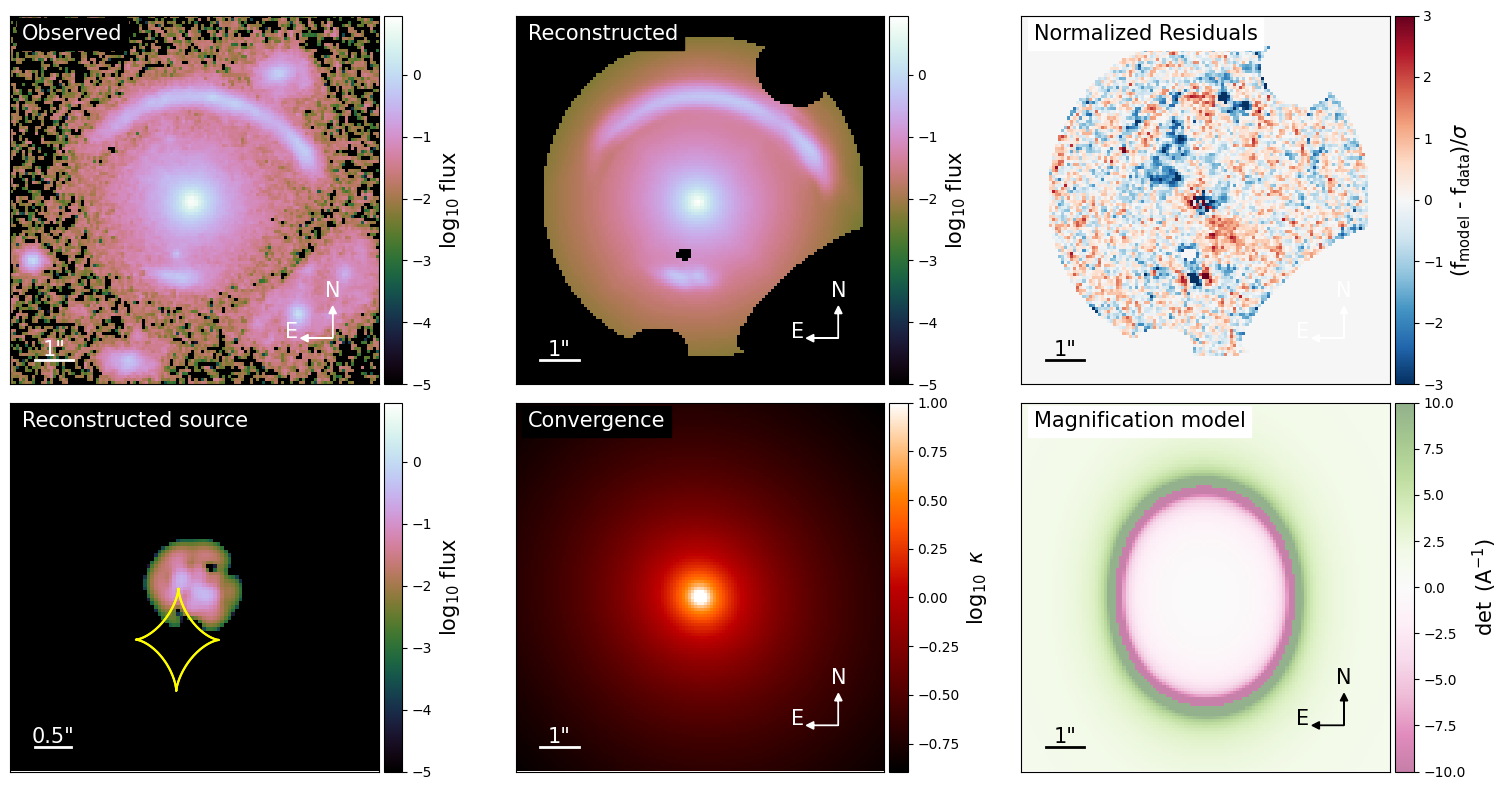

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


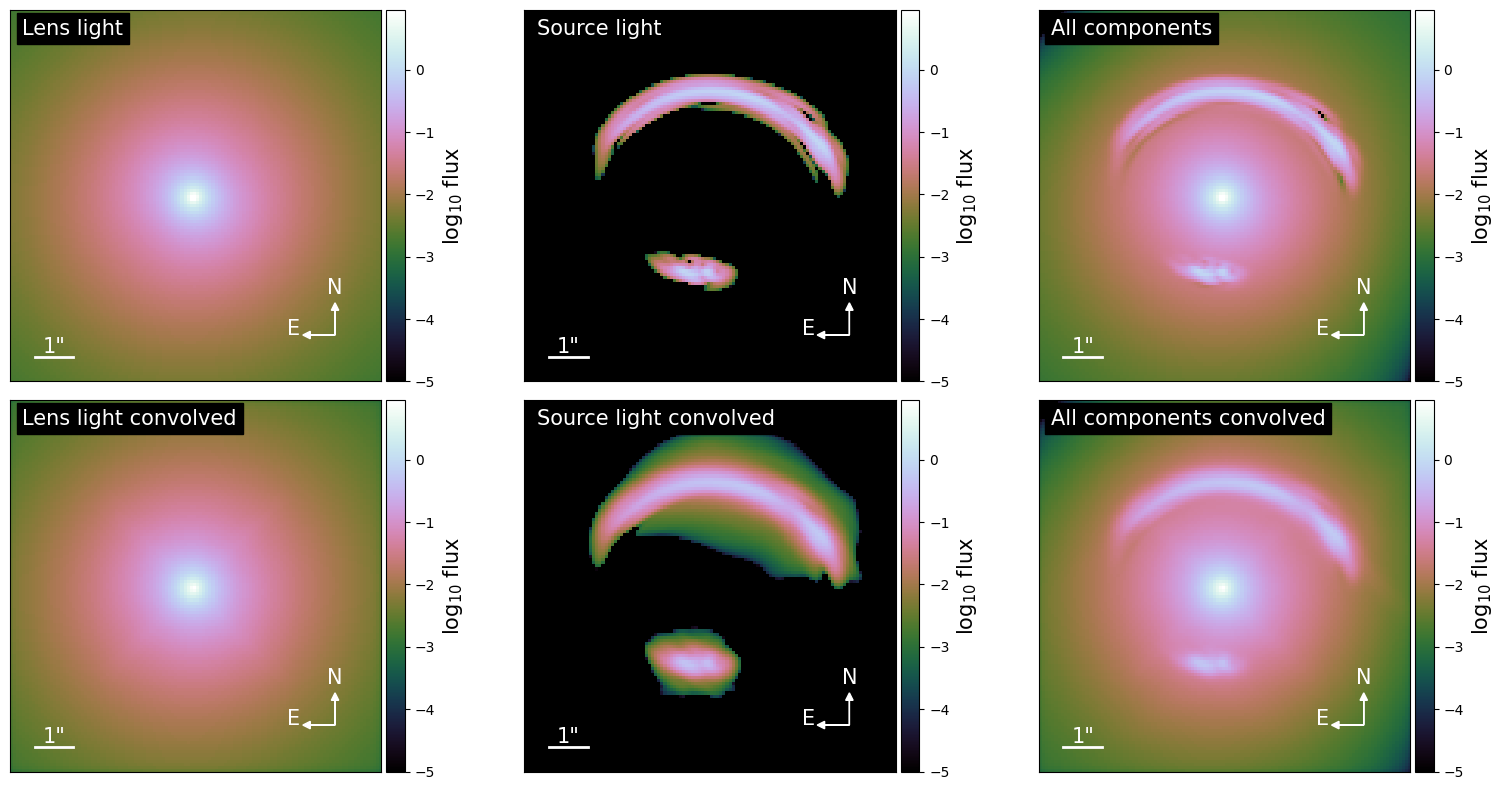

{'kwargs_lens': [{'theta_E': 2.5714669522198657, 'gamma': 2.162479593173576, 'e1': 0.0017024118211980935, 'e2': 0.030671367072154926, 'center_x': 0.08775892892269022, 'center_y': -0.3419007118593511}, {'gamma1': 0.12169450525932521, 'gamma2': 0.021263685849490902, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -0.0976127709744849, 'R_sersic': 7.591183392726291, 'n_sersic': 1.0, 'e1': -0.0344482791954194, 'e2': 0.47299358718730644, 'center_x': -0.14618566176598136, 'center_y': 0.3290316299362765}, {'amp': array([211.24813623,  -2.28324737, -50.59971616, 101.60186333,
       104.86350221,  51.25454552,  39.31171896,  -5.01007325,
       -14.0368716 ,  -6.33052163,   9.04413811,   7.87689752,
        24.82946033, -17.28908752,  10.45305176, -10.62510218,
       -15.17973636,  -0.67708533,   5.08650186,   4.99905158,
         2.36212389,  -2.44901008, -23.97548251,   4.32251943,
        15.88040315,  -2.62673228,  14.48034022,   8.64203666,
        13.53079337,   6.23669779,   6.364249

In [29]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, 
                      arrow_size=0.02, cmap_string="cubehelix",
                      image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'])

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0,0])
model_plot.model_plot(ax=axes[0,1])
model_plot.normalized_residual_plot(ax=axes[0,2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')


model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.05, with_caustics=True,
                       scale_size=0.5, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., 
                  hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0,0], text='Lens light', 
                             lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', 
                             lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0,1], text='Source light', 
                             source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,1], text='Source light convolved', 
                             source_add=True)
model_plot.decomposition_plot(ax=axes[0,2], text='All components', 
                             source_add=True, lens_light_add=True, 
                             unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,2], text='All components convolved', 
                             source_add=True, 
                             lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, 
                  wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)